# Fastai implementation of RandAugment

> This notebook contains implementation of the randaugment item transform

In [ ]:
#default_exp randaugment

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#export
import random
import cv2
import numpy as np

from fastai2.data.core import Transform
from fastai2.vision.core import PILImage

from PIL import ImageOps, ImageEnhance, ImageFilter, Image
from albumentations import Cutout
from albumentations.augmentations.functional import shift_scale_rotate

In [ ]:
import matplotlib.pyplot as plt
from fastai2.data.all import untar_data, URLs
from fastai2.vision.all import get_image_files

cifar = untar_data(URLs.CIFAR)
img = Image.open(get_image_files(cifar)[0])

All transformations as functions `f(img, level)`, where level is in $[0, \texttt{PARAMETER_MAX}]$ as in randaugment paper.

In [ ]:
#export
PARAMETER_MAX=10

def float_parameter(level, maxval):
    "Helper function to scale `val` between 0 and maxval."
    return float(level) * maxval / PARAMETER_MAX

def int_parameter(level, maxval):
    "Helper function to scale `val` between 0 and maxval."
    return int(level * maxval / PARAMETER_MAX)

We use standard geometric transforms, pixel level color transforms and cutout (cutout was used in UDA implementation, and is also present in randaugment) from PIL and albumenations. Geometric transforms:

In [ ]:
#export
def flip_lr(img, level):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def flip_ud(img, level):
    return img.transpose(Image.FLIP_TOP_BOTTOM)

def rotate(img, level):
    "Rotate for 30 degrees max"
    degrees = int_parameter(level, 30)
    if random.random() < 0.5:
        degrees = -degrees
    return Image.fromarray(shift_scale_rotate(np.array(img), degrees, 1.0, 0, 0))

def scale(img, level):
    "Scale image with level. Zoom in/out at random"
    v = float_parameter(level, 1.0)
    if random.random() < 0.5:
        v = -v * 0.4
    return Image.fromarray(shift_scale_rotate(np.array(img), 0, v + 1.0, 0, 0))

def shift(img, level):
    "Do shift with level strength in random directions"
    s = int_parameter(level, 10)
    do_x, do_y = random.choice([(0,1), (0,-1), (1,0), (-1,0), (1,1), (-1,1), (1,-1)])
    return Image.fromarray(shift_scale_rotate(np.array(img), 0, 1.0, do_x * s, do_y * s))

def cutout(img, level):
    "Cutout `level` blocks from image"
    level = int_parameter(level, 10)
    aug = Cutout(num_holes=level, always_apply=True)
    return Image.fromarray(aug(image=np.array(img))["image"])

# Random perspective 
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float32)
    B = np.array(pb).reshape(8)

    res = np.linalg.inv(A.T * A) * A.T @ B
    return np.r_[np.array(res).flatten(), 1].reshape(3,3)


def perspective(img, level):
    w, h = img.size
    y, x = float_parameter(level, 8), float_parameter(level, 8)
    if random.random() < 0.5: y = -y
    if random.random() < 0.5: x = -x

    # Compute perspective warp coordinates
    orig =  [(0, 0), (h, 0), (h, w), (0, w)]
    persp = [(0-y, 0-x), (h+y, 0+x), (h+y, w+x), (0-y, w-x)]
    coefs = find_coeffs(orig, persp)
    
    img = np.array(img).astype(np.float32) / 255.
    persp_img = cv2.warpPerspective(
        img, 
        coefs, 
        (h,w), 
        cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REFLECT101
    )
    return Image.fromarray((persp_img * 255.).astype(np.uint8))

Color transforms include, inversion, autocontrast, histogram equalization, contrast change, color change, brightness change, sharpness change. For contrast, color, brightness and sharpness we manually select ranges (e.g color could change to black and white, or realy vivid based on the value of `level` parameter + randomness).

In [ ]:
#export
def invert(img, level):
    "Negative image"
    return ImageOps.invert(img)

def equalize(img, level):
    "Equalize image histogram"
    return ImageOps.equalize(img)

def posterize(img, level):
    "Control bits count used to store colors"
    bits = 5 - int_parameter(level, 4)
    return ImageOps.posterize(img, bits)

def contrast(img, level):
    "Change contrast with param in [0.5, 1.0, 3.0]"
    v = float_parameter(level, 2.0)
    if random.random() < 0.5:
        v = -v / 4.0
    return ImageEnhance.Contrast(img).enhance(v + 1.0)

def color(img, level):
    "Change color with param in [0, 1.0, 3.0]"
    v = float_parameter(level, 2.0)
    if random.random() < 0.5:
        v = -v / 2.0
    return ImageEnhance.Color(img).enhance(v + 1.0)

def brightness(img, level):
    "Controll brightness with param in [1/3, 2.0]"
    v = float_parameter(level, 1.0)
    if random.random() < 0.5:
        v = -v / 1.5
    return ImageEnhance.Brightness(img).enhance(v + 1.0)

def sharpness(img, level):
    "Controll sharpness with param in [0, 4]"
    v = float_parameter(level, 3.0)
    if random.random() < 0.5:
        v = -v / 3.0
    return ImageEnhance.Sharpness(img).enhance(v + 1.0)

All implemented transforms:

In [ ]:
#export
ALL_TRANSFORMS = [
    flip_lr, 
    flip_ud, 
    rotate, 
    scale, 
    shift, 
    cutout, 
    perspective,
    invert,
    equalize,
    posterize,
    contrast,
    color,
    brightness,
    sharpness
]

Visualize transforms

In [ ]:
def identity(img, level):
    return img

Showing all 14 transformations


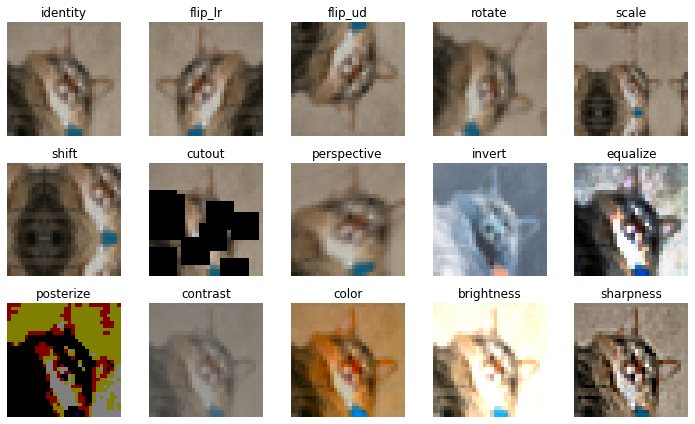

In [ ]:
plt.figure(figsize=(10,6))
cnt = len(all_transforms)
print(f"Showing all {cnt} transformations")

for i, t in enumerate([identity] + ALL_TRANSFORMS, 1):
    plt.subplot((cnt + 1) // 5 + (cnt+1) % 5, 5, i)
    plt.imshow(t(img, 10))
    plt.axis(False)
    plt.title(t.__name__)

plt.tight_layout()
plt.show()

Policy, randomly choosing 2 transformations

In [ ]:
#export

class RandAugment(Transform):
    "Apply randaugment augmentation policy"
    def __init__(self):
        ops = []
        self.policies = []
        for t in ALL_TRANSFORMS:
            for m in range(1, 11):
                ops += [(t, 0.5, m)]
        
        for op1 in ops:
            for op2 in ops:
                self.policies += [[op1, op2]]
        
    def encodes(self, img: PILImage):
        policy = random.choice(self.policies)
        x = img

        for op, p, m in policy:
            if random.random() < p:
                x = op(x, m)
        return x

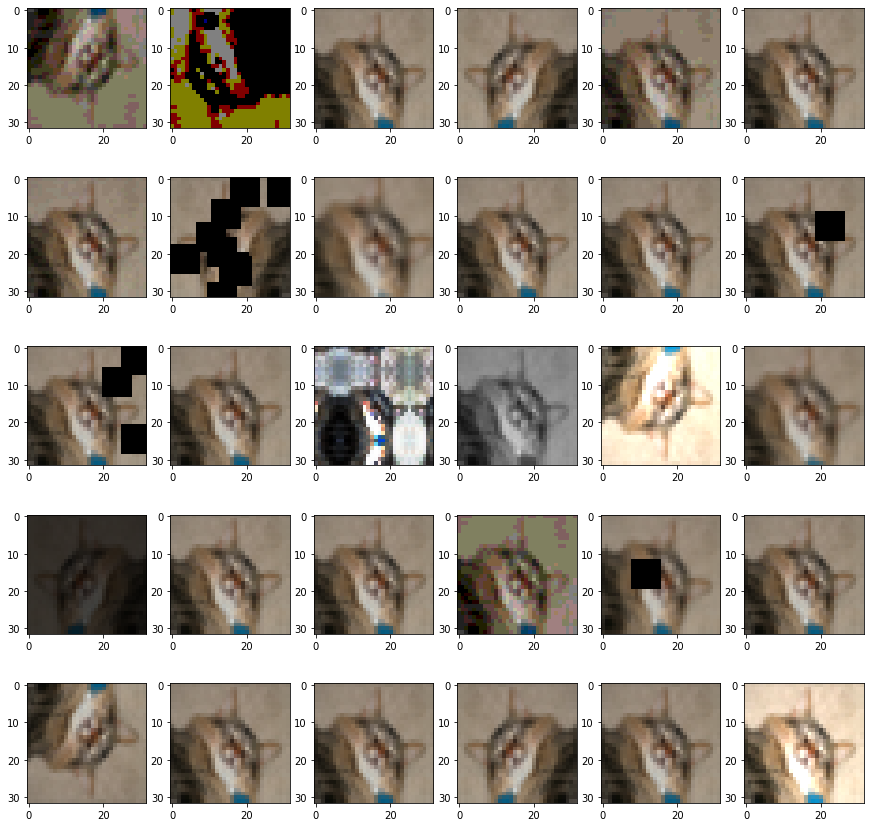

In [ ]:
ra = RandAugment()

plt.figure(figsize=(15,15))
for i in range(1,31):
    plt.subplot(5,6,i)
    plt.imshow(ra(PILImage.create(files[0])))
plt.show()

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_cifar.ipynb.
Converted 01_randaugment.ipynb.
Converted 02_supervised_baselines.ipynb.
Converted index.ipynb.
